# Groundwater Flow Induced by Topography

The darcy flow solver, ``uw.systems.SteadyStateDarcyFlow``, can solve for ground-water flow induced by an imposed pressure-gradient. In this example we show how groundwater flow beneath hetereogeneous topography can be modelled in each of these two ways.

A simple 2D hill model is set up with 3 layers, which are assigned hydraulic and thermal properties. The values of these parameters are inferred from some synthetic observations using the neighbourhood algorithm.

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
uw.utils.matplotlib_inline()

## Set up the mesh

Initialise a Q1 finite element mesh and mesh variables

In [2]:
deformedmesh = True

elementType = "Q1"
resX = 256
resY = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (0., -12000.), 
                                 maxCoord    = (30000., 0.)) 

gwHydraulicHeadField       = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField  = mesh.add_variable( nodeDofCount=1 )
velocityField              = mesh.add_variable(nodeDofCount=2)

## Deform mesh to surface topography

We make a  hill using a defined wavelength

In [3]:
xcoords = np.linspace(0,30000,resX)
ycoords = np.linspace(-12000,0,resY)

# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -0.5

def topo_coords(x, hillsize, hillwavelength):
    return hillsize*x/4*np.cos(x*hillwavelength*np.pi)
    

In [4]:
# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -10000.

yCoordFn = uw.function.input()[1]
xCoordFn = uw.function.input()[0]

# ramp option
ydel = hillsize  * (xCoordFn )/4. * uw.function.math.cos(xCoordFn * hillwavelength * np.pi)

if deformedmesh:
    with mesh.deform_mesh():
        for i in range(len(mesh.data[:])):
            y = mesh.data[i,1]
            if y >= ydeform:
                delY = ydel.evaluate((mesh.data[i,0],mesh.data[i,1])) #0.1 * (mesh.data[i,0] + 1.)/2.
                dY = (y - ydeform)/(-ydeform) * delY

                mesh.data[i,1] += dY

In [5]:
mesh.minCoord[1]

-12000.0


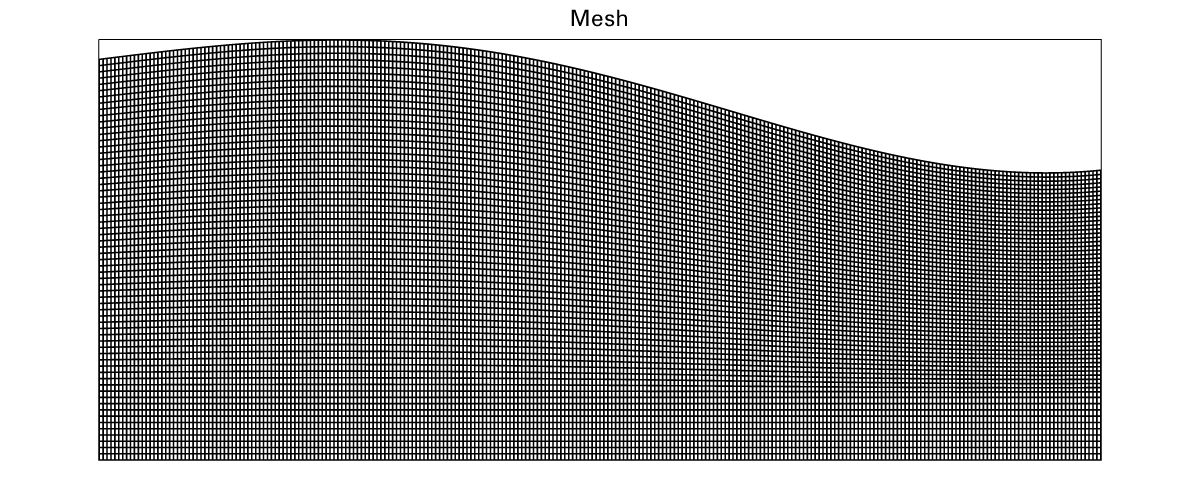

In [6]:
figMaterial = vis.Figure( figsize=(1200,500), title="Mesh" )
figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()

## Set up the types of boundary conditions

We'll set the left, right and bottom walls such that flow cannot pass through them, only parallel.
In other words for hydraulic head $h$:

$ \frac{\partial h}{\partial x}=0$ : left and right walls

$ \frac{\partial h}{\partial y}=0$ : bottom wall

This is only solvable if there is topography or a hydraulic head upper BC.

In [7]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]


gwHydraulicHeadBC = uw.conditions.DirichletCondition( variable        = gwHydraulicHeadField, 
                                                      indexSetsPerDof = ( topWall   ) )

# assign the hydraulic head upper BC to match the mesh
gwHydraulicHeadField.data[:] = yCoordFn.evaluate(mesh)

In [8]:
gwHydraulicHeadField.data[:].max()

580.44561878585137

*Set initial conditions and the values of the boundary conditions. Because the upper BC is a dirichlet condition, the upper wall is constrained to the value we set now. For the rest of the domain, it is helpful to set an increasing groundwater pressure gradient, but the values will be changed during the solution.*

## Set up particle swarm

Each cell contains particles that must be assigned isotropic thermal and hydralic properties. In 2D it is fine to set only one particle per cell to prevent variations in hydaulic diffusivity within cells.

In [9]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=4)
swarm.populate_using_layout( layout=swarmLayout )

In [10]:
materialIndex        = swarm.add_variable( dataType="int",    count=1 )
swarmVelocity        = swarm.add_variable( dataType="double", count=2 )
hydraulicDiffusivity = swarm.add_variable( dataType="double", count=1 )

materialPorous        = 0
materialImpermeable   = 1

xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

conditions = [ (yCoordFn > -0.5, materialPorous),
               (xCoordFn < -1. , materialPorous),
               (True , materialImpermeable )]


# materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)

## Assign material properties

Each 'lithology' is assigned a material index belonging to each particle. Starting values of the hydraulic diffusivity are provided.

In [11]:
materialIndex.data[:] = 1
hydraulicDiffusivity.data[:] = 1e-11

In [12]:
# vertex_array0 = np.array( [(mesh.minCoord[0],-500),(1550,-650),(mesh.minCoord[0],-800)] )
# polyfn0 = uw.function.shape.Polygon(vertex_array0)

# vertex_array1 = np.array( [(mesh.maxCoord[0],-500),(1450,-650),(mesh.maxCoord[0],-800)] )
# polyfn1 = uw.function.shape.Polygon(vertex_array1)



# for index in range( len(swarm.particleCoordinates.data) ):
#     coord = swarm.particleCoordinates.data[index][:]
#     if polyfn0.evaluate(tuple(coord)):
#             materialIndex.data[index] = 2        
#     if polyfn1.evaluate(tuple(coord)):
#             materialIndex.data[index] = 3

In [13]:
x = np.arange(mesh.minCoord[0], mesh.maxCoord[0])

In [14]:
layer_thickness = 500*(np.cos(x/5000)+1.2)

In [15]:
f = interpolate.interp1d(x, (mesh.minCoord[1] / 2) - layer_thickness)

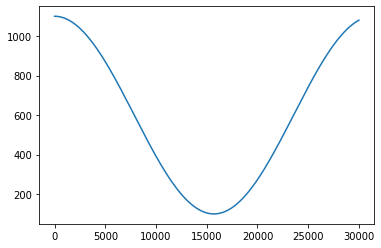

In [16]:
import matplotlib.pyplot as plt
plt.plot(x, layer_thickness)

In [17]:
# materialIndex.data[:][(swarm.data[:,1] > (-5000)) & (swarm.data[:,1] < (-4900))] = 2

# hydraulicDiffusivity.data[materialIndex.data[:] == 2] = 1e-5

materialIndex.data[:][(swarm.data[:,1] < (mesh.minCoord[1] / 2)) & (swarm.data[:,1] > f(swarm.data[:,0]))] = 3


hydraulicDiffusivity.data[materialIndex.data[:] == 3] = 1e-5




In [18]:
# # thicknesses
# matIndex = [1,2,3]
# matDiffusivity = [1e-8, 1e-8, 1e-8] # uniform
# zthick = [1000.0, 5000.0, 20000]

# materialIndex.data[:] = 0
# hydraulicDiffusivity.data[:] = 1e-12

# for i in range(xcoords.size - 1):
#     x0 = xcoords[i]
#     x1 = xcoords[i+1]
    
#     yref = float(mesh.data[topWall,1][i])
    
#     mask_x = np.logical_and(swarm.data[:,0] >= x0, swarm.data[:,0] < x1)
#     idx = np.nonzero(mask_x)[0]
    
#     for index, dy in zip(matIndex, zthick):
#         mask_y = np.logical_and(swarm.data[mask_x,1] >= yref-dy, swarm.data[mask_x,1] < yref)
#         materialIndex.data[idx[mask_y]] = index
        
#         yref -= dy
        
        


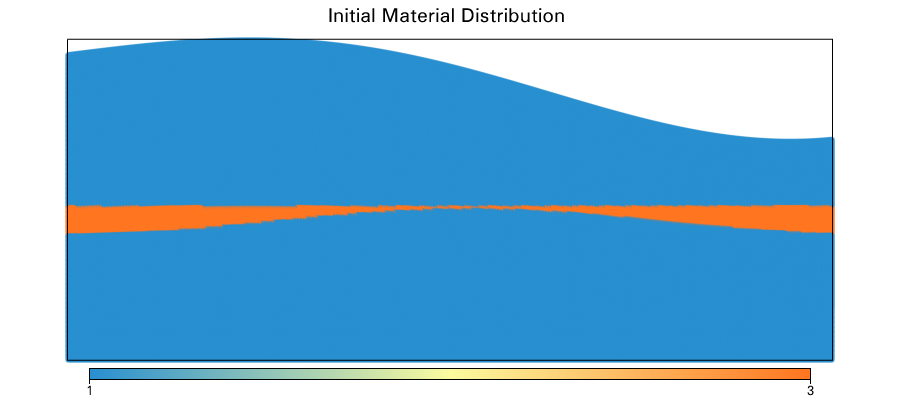

In [19]:
figMaterial = vis.Figure( figsize=(900,400), title="Initial Material Distribution" )
figMaterial.append( vis.objects.Points(swarm, materialIndex, pointSize=6.0) )
# figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()

In [20]:
# # map diffusivity field using the material index

# for i, index in enumerate(matIndex):
#     mask_index = materialIndex.data == index
#     hydraulicDiffusivity.data[mask_index] = matDiffusivity[i]
    
# # project from swarm to the mesh
# hydproj = uw.utils.MeshVariable_Projection(hydraulicDiffusivityField,hydraulicDiffusivity,swarm)
# hydproj.solve()


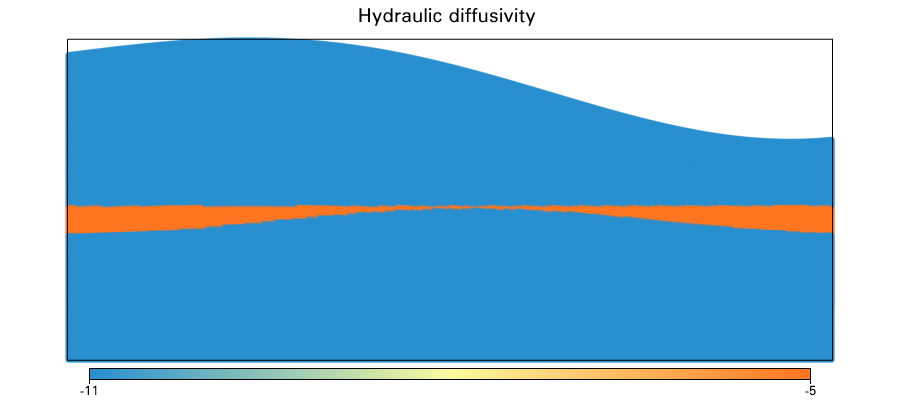

In [21]:
figMaterial = vis.Figure( figsize=(900,400), title="Hydraulic diffusivity" )
figMaterial.append( vis.objects.Points(swarm, uw.function.math.log10(hydraulicDiffusivity), pointSize=6.0) )
figMaterial.show()

*Setup groundwater equations*

In [22]:

gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                            pressureField = gwHydraulicHeadField, 
                                            fn_diffusivity = hydraulicDiffusivity,
                                            conditions=[gwHydraulicHeadBC],
                                            fn_bodyforce=(0., 0.),
                                            voronoi_swarm=swarm,
                                            swarmVarVelocity=swarmVelocity)


gwsolver = uw.systems.Solver(gwadvDiff)

/opt/venv/lib/python3.8/site-packages/underworld/systems/_darcyflow.py:123: UserWarning: It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.
  warnings.warn("It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.")


In [23]:
gwsolver.solve()

In [24]:
obs_coords = np.array([[29500.0,-6000.]])
gwHydraulicHeadField.evaluate(obs_coords)

array([[-0.69900738]])


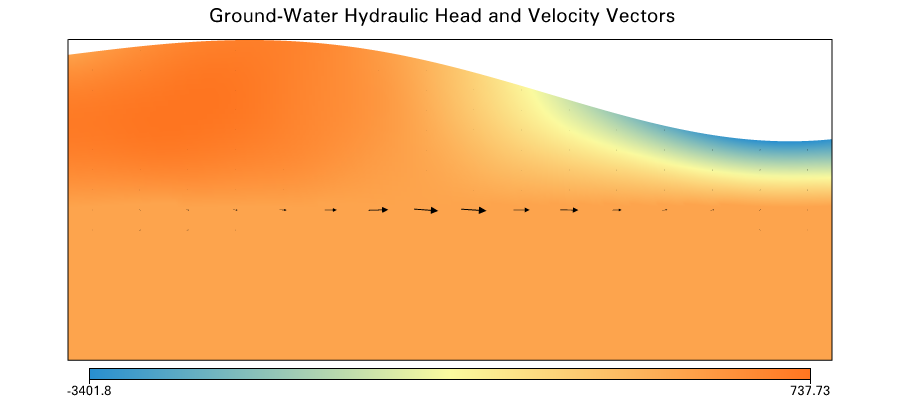

max velocity = 2.73918240066897e-10


In [25]:
figMaterial = vis.Figure( figsize=(900,400),title="Ground-Water Hydraulic Head and Velocity Vectors" )
figMaterial.append(vis.objects.Surface(mesh, gwHydraulicHeadField, onMesh=True))
scale = 0.03
figMaterial.append(vis.objects.VectorArrows(mesh,velocityField,scaling=1,arrowHead=0.3))
figMaterial.show()

print("max velocity = {}".format(np.abs(velocityField.data).max()))

Here are some metrics, notice that there is a slight change depending on whether or not the deformed mesh / gravity term combination is used.

In [26]:
# If in parallel, every CPU will report these metrics for its own domain.
print("Max horiz. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,0])))
print("Max vert. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,1])))
print("Max pressure: %.4e" %np.max(gwHydraulicHeadField.data[:]))
print("Min pressure: %.4e" %np.min(gwHydraulicHeadField.data[:]))

Max horiz. velocity: 1.1445e-09
Max vert. velocity: 7.9122e-10
Max pressure: 7.3773e+02
Min pressure: -3.4018e+03


In [27]:
print("This model was run successfully to completion using underworld {}".format(uw.__version__))

This model was run successfully to completion using underworld 2.11.0b
